# Coronavirus Prevalence, Death Rate and Herd Immunity

On April 22 
https://www.turnto23.com/news/coronavirus/video-interview-with-dr-dan-erickson-and-dr-artin-massihi-taken-down-from-youtube
cases and deaths by country and state.

Datasets wanted:

- location data
- testing by country and state
- population age structure? 
- lockdowns (and other interventions) by country and state

Plot ideas:

- plot rank change to see which ones are trending worse and which are trending better
- plot dpm change / dpm to plot the growth rate (slope) over time
- plt dpm change to plot the rate * base - base, which relates to hospital capacity.


In [1]:
import datetime
from pprint import pprint
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  
import numpy as np
import pandas as pd
from pathlib import Path
import plotly.express as px
from scipy.special import gamma
from sklearn.metrics import mutual_info_score
from sklearn.feature_selection import mutual_info_regression
import time
import timeit

from coronavirus.data import load_covidtracking_state_data
from coronavirus.data import load_all, load_nyc_age_comorbidity_death_data
from coronavirus.data import fill_before_first

%reload_ext autoreload
%autoreload 2
%matplotlib inline

## Load Data

In [3]:
# takes a minute
states_df, countries_df, all_df = load_all(download=False)


## Erickson Analysis of Death Rate

In [274]:
df = states_df
# erickson briefing: https://www.youtube.com/watch?v=xfLVxx_lBLU
# erickson population infection rate estimated from cases-per-test
# erickson population cases estimated as infection rate * population
# erickson population chance of death is deaths per population case 
# herd chance of death says, what if the population prevalence is 60% and the death rate remains the same.
#   then herd chance of death is: deaths / (pop prevalence)  deaths per population case

# confirmed cases is a vast underestimate of true cases, since many/most cases are not tested.
#   antibody studies place the population cases at ~16x to 55x (or more) the confirmed cases.
# erickson estimates the true cases using cases-per-test * population. Based on the antibody
#   studies coming out, this seems like an overestimate of the true cases, by ~1-7x?

df['cases_per_capita'] = df['cases'] / df['population']
df['erickson_cases'] = (df['cases_per_test'] * df['population']).round()
df['erickson_cases_per_capita'] = df['cases_per_test']
df['erickson_deaths_per_case'] = df['deaths'] / df['erickson_cases']
df['erickson_cases_per_confirmed_case'] = df['erickson_cases'] / df['cases']
df['herd_cases'] = df['population'] * 0.6
df['herd_dpm'] = df['deaths_per_case'] * 1e6 * 0.6
df['herd_erickson_dpm'] = df['erickson_deaths_per_case'] * 1e6 * 0.6
# df['herd_deaths']
# df['herd_chance_of_death'] = df['erickson_chance_of_death'] * (0.6 / df['cases_per_test']) 
df['erickson_cases'] = df['erickson_cases'].apply(lambda x: x if pd.isnull(x) else int(x))

In [263]:
(df
 .loc[df['entity'].isin(['New York', 'Massachusetts', 'California']), [
     'entity', 'date', 
     'deaths', 
     'tests', 
     'cases',
     'population', 
 ]]
 .groupby('entity').last()
)


,date,deaths,tests,cases,population
entity,,,,,
California,2020-04-26,1710.0,526084.0,42164.0,39512223
Massachusetts,2020-04-26,2899.0,236100.0,54938.0,6892503
New York,2020-04-26,16966.0,805350.0,288045.0,19453561


In [264]:
(df
 .loc[df['entity'].isin(['New York', 'Massachusetts', 'California']), [
     'entity', 'date', 
     'deaths_per_case',
 ]]
 .groupby('entity').last()
)


,date,deaths_per_case
entity,,
California,2020-04-26,0.040556
Massachusetts,2020-04-26,0.052769
New York,2020-04-26,0.058901


In [265]:
(df
 .loc[df['entity'].isin(['New York', 'Massachusetts', 'California']), [
     'entity', 'date', 
     'cases_per_test',
     'erickson_cases',
     'erickson_deaths_per_case',
 ]]
 .groupby('entity').last()
)


,date,cases_per_test,erickson_cases,erickson_deaths_per_case
entity,,,,
California,2020-04-26,0.080147,3166782.0,0.000540
Massachusetts,2020-04-26,0.232690,1603813.0,0.001808
New York,2020-04-26,0.357664,6957846.0,0.002438


In [267]:
(df
 .loc[df['entity'].isin(['New York', 'Massachusetts', 'California']), [
     'entity', 'date', 
     'erickson_cases_per_confirmed_case',
 ]]
 .groupby('entity').last()
)


,date,erickson_cases_per_confirmed_case
entity,,
California,2020-04-26,75.106299
Massachusetts,2020-04-26,29.193145
New York,2020-04-26,24.155413


In [273]:
(df
 .loc[df['entity'].isin(['New York', 'Massachusetts', 'California']), [
     'entity', 'date', 
     'herd_dpm',
     'herd_erickson_dpm',
 ]]
 .groupby('entity').last().sort_values(by='herd_erickson_dpm')
)

,date,herd_dpm,herd_erickson_dpm
entity,,,
California,2020-04-26,24333.554691,323.988200
Massachusetts,2020-04-26,31661.145291,1084.540405
New York,2020-04-26,35340.311410,1463.038992


In [215]:
df['nys_multiple'] = (0.144 * df['population']) / df['cases']
df.loc[df['entity'] == 'New York', :].tail()

,date,entity,cases,deaths,tests,population,cases_per_million,cases_per_day,cases_per_day_7day_avg,cases_per_day_3day_avg,...,deaths_per_day_3day_avg_tests_per_day_3day_avg_ratio_14day_ratio,deaths_per_test_per_day_3day_avg_14day_ratio,erickson_chance_of_death,herd_chance_of_death,erickson_cases,erickson_deaths_per_case,cases_to_erickson_cases,erickson_cases_to_cases,cases_per_capita,nys_multiple
1789,2020-04-22,New York,257216.0,15302.0,669982.0,19453561,13222.052250,5526.0,6205.285714,4810.000000,...,0.814852,0.822577,0.002049,0.003202,7.468510e+06,0.002049,0.034440,29.035946,0.013222,10.890896
1788,2020-04-23,New York,263460.0,15740.0,695920.0,19453561,13543.021763,6244.0,5882.285714,5316.000000,...,0.687662,0.714432,0.002137,0.003387,7.364690e+06,0.002137,0.035773,27.953732,0.013543,10.632782
1787,2020-04-24,New York,271590.0,16162.0,730656.0,19453561,13960.940108,8130.0,5992.571429,6633.333333,...,0.542050,0.572387,0.002235,0.003608,7.231026e+06,0.002235,0.037559,26.624788,0.013961,10.314492
1786,2020-04-25,New York,282143.0,16599.0,777568.0,19453561,14503.411483,10553.0,6487.285714,8309.000000,...,0.387508,0.409393,0.002352,0.003888,7.058786e+06,0.002352,0.039970,25.018469,0.014503,9.928699
1785,2020-04-26,New York,288045.0,16966.0,805350.0,19453561,14806.800667,5902.0,6465.571429,8195.000000,...,0.338580,0.346168,0.002438,0.004091,6.957846e+06,0.002438,0.041399,24.155412,0.014807,9.725261


Feedback on my email.

> Thanks Todd this is great! Very accessible writing. 

> Can you add an analysis and conclusion for the old and sick?

> Also re: your conclusion for society (and other "open it up!" advocates)...
> 
> - About 1/3 of Americans are 60 or older
> - About the same percentage of adults have hypertension 
> - 10.5% are diabetic
> - 40% of adults are obese

> These are not additive, of course, but we are talking about simultaneously isolating and protecting between 1/3 and greater than 50% of people, while everyone else gets a disease. That is a fantasy. If we are getting to 60% antibodies, a lot of people over 60 and with comorbidities are getting it too. 

> Also, the current economic damage is not being done by a hard lockdown. Most places have a soft lockdown or less (many categories of stores open, huge categories of workers considered essential, freedom to travel and use public streets and, in most cases, open parks).  There is guidance to stay at home and many people are choosing to limit travel and activity because they have a legitimate fear for someone over 60 or with comorbidities. So, what reduction in activity is reasonable for a disease with a death rate for those over 60 and with comorbidities of, say 1%-5%? Closed stadiums, concert venues and movie theaters? Limited international travel? Increased spacing in bars and restaurants? Avoiding amusement parks and cruises? Pretty quickly it adds up to, what, 10% of the economy? 20%? Shutting that fraction of the economy for months and months is devastating and inevitable if it the disease is at epidemic levels.

## New York City: Age and Comorbidities

Explore how the case fatality rate differs for younger cohorts vs the entire population of cases. Explore how many of the people dying have comorbidities.

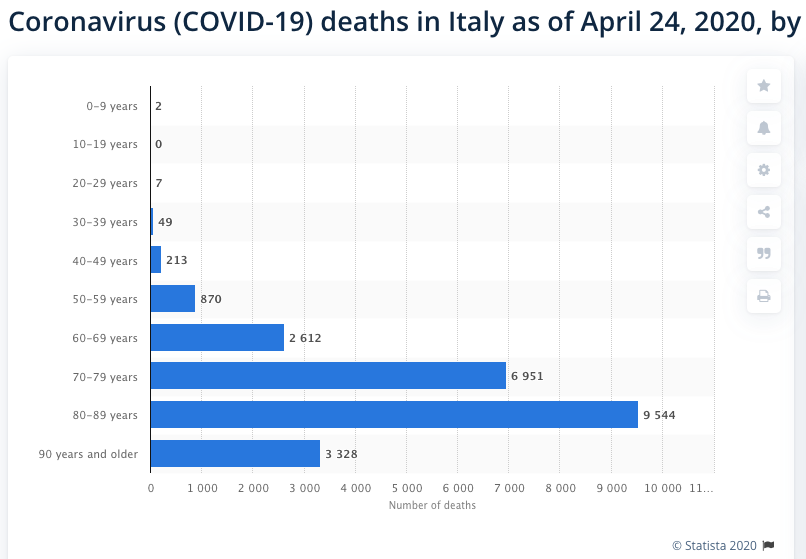

In [289]:
deaths_df, df = load_nyc_age_comorbidity_death_data()
print(deaths_df.pivot(index='age_band', columns='comorbidity'))
# print(df)
deaths_df.groupby('age_band').sum()['deaths']

# nyc deaths-per-case
print('NYC deaths_per_case')
print(df['deaths'].sum() / df['cases'].sum())
# nyc deaths-per-case under 65
print('NYC deaths_per_case under 65')
u65 = df.loc[df['age_band'].isin(['0-17', '18-44', '45-64'])]
u65_deaths_per_case = u65['deaths'].sum() / u65['cases'].sum()
print(u65_deaths_per_case)
# nyc deaths-per-case under 45
print('NYC deaths_per_case under 45')
u45 = df.loc[df['age_band'].isin(['0-17', '18-44'])]
u45_deaths_per_case = u45['deaths'].sum() / u45['cases'].sum()
print(u45_deaths_per_case)
# among people who are dying, what fraction of them have comorbidities?
comorb = deaths_df.groupby('comorbidity').sum()
print('Percent of NYC deaths with comorbidity')
high_comorb_pct = (comorb.loc['yes', 'deaths'] + comorb.loc['unknown', 'deaths']) / comorb['deaths'].sum()
low_comorb_pct = comorb.loc['yes', 'deaths'] / comorb['deaths'].sum()
no_unk_comorb_pct = comorb.loc['yes', 'deaths'] / (comorb.loc['yes', 'deaths'] + comorb.loc['no', 'deaths'])
print(low_comorb_pct, no_unk_comorb_pct, high_comorb_pct)


            deaths              
comorbidity     no unknown   yes
age_band                        
0-17             0       0     5
18-44           10      90   379
45-64           50     366  2204
65-74            5     829  2050
75 and over      1    1923  3794
unknown          0       2     0
NYC deaths_per_case
0.07500320307495195
NYC deaths_per_case under 65
0.026192766610973285
NYC deaths_per_case under 45
0.007940935192780968
Percent of NYC deaths with comorbidity
0.7201913221728733 0.9922334666980466 0.9943628288349846
